In [1]:
import pandas as pd
import numpy as np

In [2]:
# pd.set_option('precision',2)
# locale.setlocale( locale.LC_ALL, 'English_United States.1252')
# locale._override_localeconv = {'n_sign_posn':1}

import pandas as pd
import locale

In [3]:
get_ipython().magic('matplotlib inline')
import matplotlib.pylab as plt
import seaborn as sns
# import ggplot as gg
# from ggplot import *
import bokeh as bkh
from bokeh.layouts import row
from bokeh.plotting import figure, show, output_file

In [4]:
# dataset from https://www.kaggle.com/kaggle/sf-salaries
# sf2014
sf = pd.read_csv('data/sf-salaries/Salaries.csv', usecols=[0,1,2,3,4,5,6,7,9,11,12], dtype={3: object, 4: object, 5: object, 6: object, 12: object}, na_values=['Not Provided', 'Not provided', 'not provided'])

Submission Requirements: 
    
Submit links to a Github repository containing a Jupyter notebook. The notebook should contain:

* The questions you asked
* The trends you investigated
* The resulting visualizations and conclusions.


## Defination of the columns:

### Numeric (needs conversion to numeric):
##### 1. BasePay, OvertimePay, OtherPay, Benefits, TotalPay

### Categorical:
##### 1. Id, EmployeeName, JobTitle, Agency, Status


## Starting Analysis

* Agency - Represents a region in the larger datasets.
* BasePay - The base rate of pay for a job or activity, excluding additional payments such as overtime or bonuses.
* Benefits - Employees pension plan, free health insurance, and other benefits.
* EmployeeName - Full Name (we can try to use this to analyze gender discrimination)
* Id - Original order of employees from sf2014 dataset, field does not exist in sf 2015
* JobTitle - Employee position held. (There seem to be differences in naming between datasets.)
* Notes - Empty
* OtherPay - Not sure but I would imagine Bonuses or other 'special' benefits. Could include personal flights on public aircrafts.
* OvertimePay - Time paid at California's's 1.5x base pay for over time.
* Status - Classification as FT (Full Time) or PT (Part Time) employee. Only tracked after 2013.
* TotalPay - BasePay + OvertimePay + OtherPay
* Year - Payroll year

In [5]:
sf.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,2011,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,2011,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,2011,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,2011,San Francisco,NaN


# Questions

* How many employees does San Francisco employ?
* What are the job titles of these employees?
* How much on average does SF pay?
* San Francisco payroll, as well as California, in general have a much higher payroll than other cities of similar size, is there a reason why?

In [6]:
sf.isnull().sum()

Id                   0
EmployeeName         6
JobTitle             4
BasePay            609
OvertimePay          4
OtherPay             4
Benefits         36163
TotalPay             0
Year                 0
Agency               0
Status          110535
dtype: int64

In [7]:
sf.Agency.unique()

array(['San Francisco'], dtype=object)

Since the Agency field only contains one unique value, I will remove the field. Notices field is null.

In [8]:
# del sf['Notes']

# Here is another way of dropping a field.

sf.drop(['Agency'], axis=1, inplace=True)

Here I am going to do basic data standardization and cleaning so that it is easier to work with this dataset.

In [9]:
# I am also going to delete any observation where JobTitle is 'Not provided' so that the field can be indexed
sf = sf[sf.JobTitle.notnull()]

# Filling in 'Benefits' if NaN, fill with 0
sf['Benefits'].fillna(0, inplace=True)

# Replace NaN status with "Unknown", since we don't know if its FT or PT work, easier categorization later.
# sf['Status'].fillna("Unknown", inplace=True)

# Convert all JobTitle to upper-case character so there is no differentiation in data.
sf['JobTitle'] = sf.JobTitle.str.upper()

# Convert all EmployeeName to upper-case character so there is no differentiation in data. 
# Note: I noticed in pivots duplicate entries if the letter is not standardized.
sf['EmployeeName'] = sf.EmployeeName.str.upper()

In [10]:
# Much cleaner now
sf.isnull().sum()

Id                   0
EmployeeName         2
JobTitle             0
BasePay            605
OvertimePay          0
OtherPay             0
Benefits             0
TotalPay             0
Year                 0
Status          110531
dtype: int64

NOTE: From reading on the website (where I pulled the dataset) I already saw that there records with zero BasePay, but instead amounts appear in OtherPay and TotalPay, thus 605 null BasePay records does not suprise me.

In [11]:
sf.dtypes

Id                int64
EmployeeName     object
JobTitle         object
BasePay          object
OvertimePay      object
OtherPay         object
Benefits         object
TotalPay        float64
Year              int64
Status           object
dtype: object

Now we need to convert BasePay, OvertimePay, OtherPay, Benefits to a numeric field.

In [12]:
sf.BasePay = sf.BasePay.str.lstrip('$')
sf.OtherPay = sf.OtherPay.str.lstrip('$')
sf.OvertimePay = sf.OvertimePay.str.lstrip('$')
# sf.TotalPay = sf.TotalPay.str.lstrip('$')
sf.Benefits = sf.Benefits.str.lstrip('$')

In [13]:
sf.BasePay = sf.BasePay.str.replace(',','')
sf.OtherPay = sf.OtherPay.str.replace(',','')
sf.OvertimePay = sf.OvertimePay.str.replace(',','')
# sf.TotalPay = sf.TotalPay.str.replace(',','')
sf.Benefits = sf.Benefits.str.replace(',','')

In [14]:
sf.BasePay = pd.to_numeric(sf.BasePay)
sf.OvertimePay = pd.to_numeric(sf['OvertimePay'])
sf.OtherPay = pd.to_numeric(sf['OtherPay'])
sf.Benefits = pd.to_numeric(sf['Benefits'])
sf.TotalPay = pd.to_numeric(sf['TotalPay'])

In [15]:
# sf['BasePay'] = pd.to_numeric(sf['BasePay'])
# sf['OvertimePay'] = pd.to_numeric(sf['OvertimePay'])
# sf['OtherPay'] = pd.to_numeric(sf['OtherPay'])
# sf['Benefits'] = pd.to_numeric(sf['Benefits'])
# sf['TotalPay'] = pd.to_numeric(sf['TotalPay'])

In [16]:
sf.dtypes

Id                int64
EmployeeName     object
JobTitle         object
BasePay         float64
OvertimePay     float64
OtherPay        float64
Benefits        float64
TotalPay        float64
Year              int64
Status           object
dtype: object

Above we can see that the we properly converted the fields to numeric. Now we can do calculations on numeric fields.

In [17]:
sf.describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year
count,148650.000000,148045.000000,148650.000000,148650.000000,112491.000000,148650.000000,148650.000000
mean,74325.500047,66325.448841,5066.059886,3648.767297,25007.893151,74770.333901,2012.522603
std,42911.703176,42764.635495,11454.380559,8056.601866,15402.215858,50516.196009,1.117526
min,1.000000,-166.010000,-0.010000,-7058.590000,-33.890000,-618.130000,2011.000000
25%,37163.250000,33588.200000,0.000000,0.000000,11535.395000,36169.955000,2012.000000
50%,74325.500000,65007.450000,0.000000,811.270000,28628.620000,71427.240000,2013.000000
75%,111487.750000,94691.050000,4658.175000,4236.065000,35566.855000,105842.960000,2014.000000
max,148654.000000,319275.010000,245131.880000,400184.250000,96570.660000,567595.430000,2014.000000


In [18]:
sf[sf.Year == 2014].describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year
count,38119.000000,38119.000000,38119.000000,38119.000000,38119.000000,38119.000000,38119.0
mean,129591.000184,66564.421924,5401.993737,3505.421251,24789.601756,75471.836912,2014.0
std,11004.152110,44053.783972,11769.656257,7767.114151,15703.733930,51694.645115,0.0
min,110532.000000,0.000000,0.000000,-618.130000,-13.800000,-618.130000,2014.0
25%,120061.500000,30138.055000,0.000000,0.000000,10269.975000,33468.125000,2014.0
50%,129591.000000,65055.000000,0.000000,695.890000,28426.980000,72366.280000,2014.0
75%,139120.500000,94735.050000,5113.430000,4098.135000,35445.100000,107977.950000,2014.0
max,148654.000000,318835.490000,173547.730000,342802.630000,96570.660000,471952.640000,2014.0


# Answers

* How many employees does San Francisco employ? <b>In 2014 SF employed 16,580 employees.</b>
* How much on average does SF pay? <b>On average SF employees earn $95,602.85 </b>

In [19]:
sf = sf[sf.BasePay > 0]
sf = sf[sf.OvertimePay > 0]
sf = sf[sf.OtherPay > 0]
sf = sf[sf.TotalPay > 0]



We see that there is some cleaning to do:
1. Remove negative salaries
2. There is some data with null values based on count values

In [20]:
# Min and max in the dataset
print('Min:', sf.Year.min())
print('Max:', sf.Year.max())

Min: 2011
Max: 2014


In [21]:
# Count records per year with a loop
for y in range(min(sf.Year), max(sf.Year)+1):
    print(y, (sf.Year == y).sum())

2011 15730
2012 15983
2013 16018
2014 16580


In [22]:
sf.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,2011,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,2011,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,2011,NaN
5,6,DAVID SULLIVAN,ASSISTANT DEPUTY CHIEF II,118602.00,8601.00,189082.74,NaN,316285.74,2011,NaN


In [23]:

y = sf.groupby('Year').size()
#y = y.value_counts
#sns.barplot(data = y, x = 'Year', y = 'Count')
#sns.plt.title('Employees by Year')
# sns.barplot(x = )

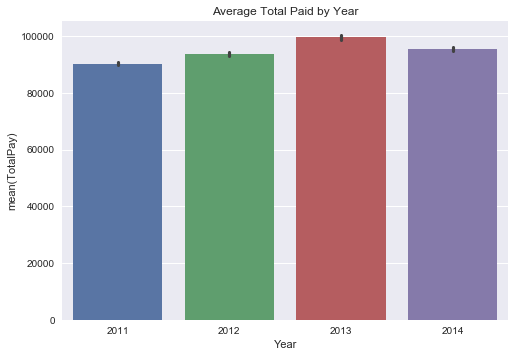

In [24]:
# Average Paid by year
sf[['Year', "TotalPay"]].groupby('Year').mean()
sns.barplot(x = "Year", y="TotalPay", data = sf)
sns.plt.title('Average Total Paid by Year')

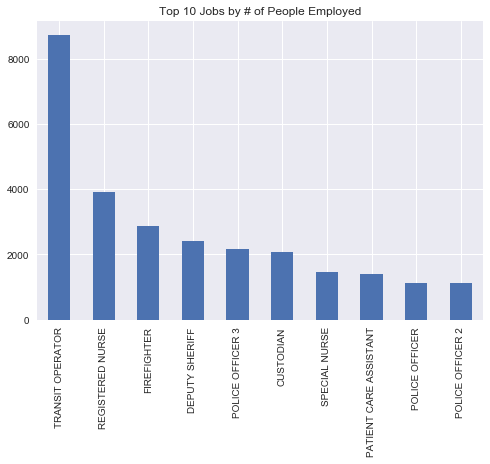

In [25]:
JobTitleCount = sf['JobTitle'].value_counts().head(10)
JobTitleCount.plot(title = "Top 10 Jobs by # of People Employed", kind = 'bar')

In [26]:
# Create a new column called 'Department'
sf['Department'] = ''

When looking at the 'JobTitles' it is clear that employees can be grouped easily into certain departments such as below:

In [27]:
sf.loc[sf.JobTitle.str.contains('POLICE'), 'Department'] = "POLICE"
sf.loc[sf.JobTitle.str.contains("FIRE"), 'Department'] = "FIRE"
sf.loc[sf.JobTitle.str.contains("MEDICAL"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("NURSE"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("TRANSIT"), 'Department'] = "TRANSIT"
sf.loc[sf.JobTitle.str.contains("AIRPORT"), 'Department'] = "AIRPORT"
sf.loc[sf.JobTitle.str.contains("WATER"), 'Department'] = "WATER"
sf.loc[sf.Department == '', 'Department'] = 'OTHER'

In [78]:
# Applying $ (currency) for formatting and attractive presentation

ByDepartment = pd.pivot_table(sf, index=['Department'], values=["TotalPay"], aggfunc=[np.sum, np.mean, len], fill_value=0)
ByDepartment.ix[:,0] = ['${:,.2f} MM'.format(x) for x in ByDepartment.ix[:,0]/1000000]
ByDepartment.ix[:,1] = ['${:,.2f}'.format(x) for x in ByDepartment.ix[:,1]]
ByDepartment

/Users/ababen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


,sum,mean,len
,TotalPay,TotalPay,TotalPay
Department,,,
AIRPORT,$49.75 MM,"$86,214.97",577
FIRE,$845.95 MM,"$158,270.02",5345
MEDICAL,$681.67 MM,"$98,407.36",6927
OTHER,"$2,725.98 MM","$82,763.34",32937
POLICE,$931.94 MM,"$130,341.83",7150
TRANSIT,$829.02 MM,"$75,427.52",10991
WATER,$34.62 MM,"$90,166.50",384


In the above table we can see the total, mean and count of Total Paid per Department

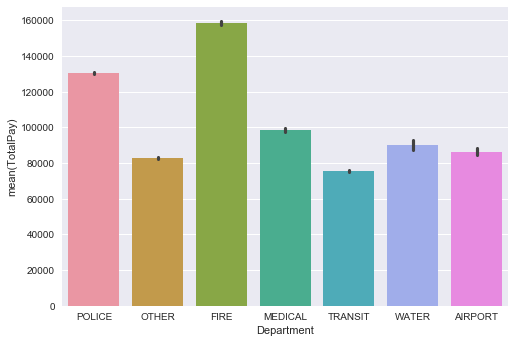

In [79]:
sns.barplot(x = "Department", y = "TotalPay", data = sf)

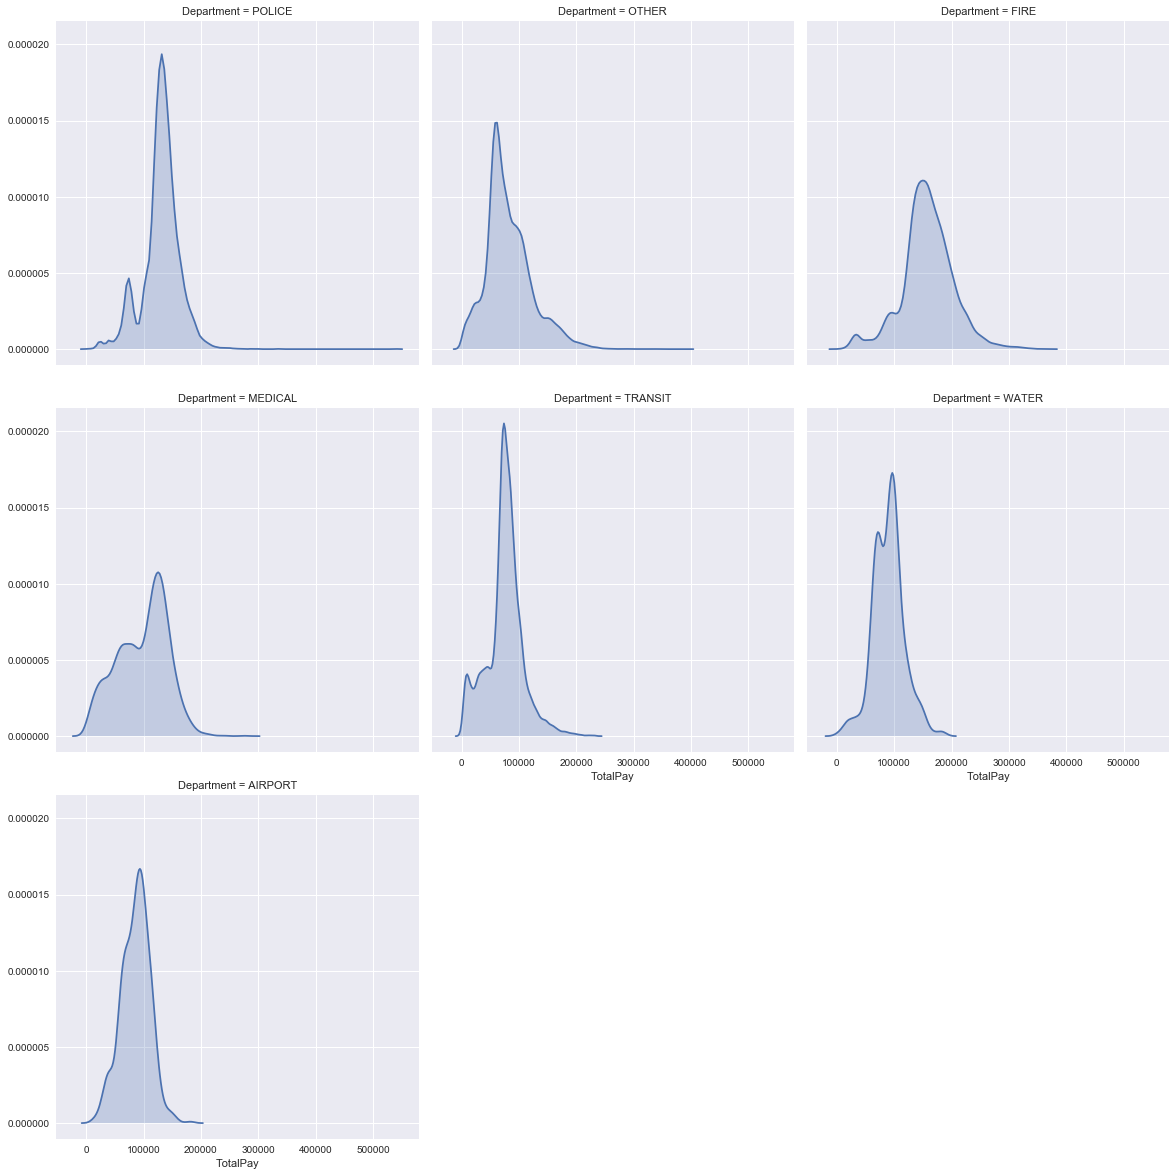

In [80]:
plot_jg = sns.FacetGrid(sf, col="Department", col_wrap=3, size=5.5, dropna=True)
plot_jg = plot_jg.map(sns.kdeplot, 'TotalPay', shade=True)

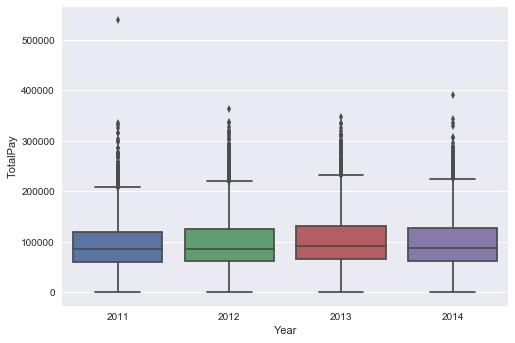

In [81]:
sns.boxplot(x="Year", y="TotalPay", data=sf)

Above we see that the salaries have not changed between the years.

# Difference in earning between genders

In [82]:
# from https://pypi.python.org/pypi/gender-guesser
import gender_guesser.detector as gender

In [83]:
d = gender.Detector(case_sensitive=False)

In [84]:
sf['FirstName'] = sf.EmployeeName.str.split(' ').str.get(0)
sf['FirstName']= sf.FirstName.str.lower()
sf.FirstName.fillna(method="backfill", inplace=True)

In [85]:
gender = []
names = []

for i in range(0, len(sf.FirstName)):
    names.append(sf.FirstName.iloc[i])
    gender.append(d.get_gender(sf.FirstName.iloc[i]))

In [86]:
# Create gender dataset

dict_gender = dict(zip(names, gender))
df_gender = pd.DataFrame()
df_gender['FirstName'] = dict_gender.keys()
df_gender['Gender'] = dict_gender.values()
sf_gender = pd.merge(sf, df_gender, how='left')
sf_gender.head(10)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status,Department,FirstName,Gender
0,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,NaN,POLICE,gary,male
1,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,2011,NaN,POLICE,albert,male
2,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,2011,NaN,OTHER,christopher,male
3,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,2011,NaN,FIRE,patrick,male
4,6,DAVID SULLIVAN,ASSISTANT DEPUTY CHIEF II,118602.00,8601.00,189082.74,NaN,316285.74,2011,NaN,OTHER,david,male
5,7,ALSON LEE,"BATTALION CHIEF, (FIRE DEPARTMENT)",92492.01,89062.90,134426.14,NaN,315981.05,2011,NaN,FIRE,alson,unknown
6,9,MICHAEL MORRIS,"BATTALION CHIEF, (FIRE DEPARTMENT)",176932.64,86362.68,40132.23,NaN,303427.55,2011,NaN,FIRE,michael,male
7,11,ARTHUR KENNEY,"ASSISTANT CHIEF OF DEPARTMENT, (FIRE DEPARTMENT)",194999.39,71344.88,33149.90,NaN,299494.17,2011,NaN,FIRE,arthur,male
8,12,PATRICIA JACKSON,CAPTAIN III (POLICE DEPARTMENT),99722.00,87082.62,110804.30,NaN,297608.92,2011,NaN,POLICE,patricia,female
9,15,DAVID FRANKLIN,"BATTALION CHIEF, (FIRE DEPARTMENT)",174872.64,74050.30,37424.11,NaN,286347.05,2011,NaN,FIRE,david,male


In [87]:
# Clean up the genders to fall into categories

sf_gender.ix[sf_gender['Gender'] == 'andy', 'Gender'] = 'unknown'
sf_gender.ix[sf_gender['Gender'] == 'mostly_female', 'Gender'] = 'female'
sf_gender.ix[sf_gender['Gender'] == 'mostly_male', 'Gender'] = 'male'
sf_gender.head(10)

/Users/ababen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status,Department,FirstName,Gender
0,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,NaN,POLICE,gary,male
1,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,2011,NaN,POLICE,albert,male
2,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,2011,NaN,OTHER,christopher,male
3,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,2011,NaN,FIRE,patrick,male
4,6,DAVID SULLIVAN,ASSISTANT DEPUTY CHIEF II,118602.00,8601.00,189082.74,NaN,316285.74,2011,NaN,OTHER,david,male
5,7,ALSON LEE,"BATTALION CHIEF, (FIRE DEPARTMENT)",92492.01,89062.90,134426.14,NaN,315981.05,2011,NaN,FIRE,alson,unknown
6,9,MICHAEL MORRIS,"BATTALION CHIEF, (FIRE DEPARTMENT)",176932.64,86362.68,40132.23,NaN,303427.55,2011,NaN,FIRE,michael,male
7,11,ARTHUR KENNEY,"ASSISTANT CHIEF OF DEPARTMENT, (FIRE DEPARTMENT)",194999.39,71344.88,33149.90,NaN,299494.17,2011,NaN,FIRE,arthur,male
8,12,PATRICIA JACKSON,CAPTAIN III (POLICE DEPARTMENT),99722.00,87082.62,110804.30,NaN,297608.92,2011,NaN,POLICE,patricia,female
9,15,DAVID FRANKLIN,"BATTALION CHIEF, (FIRE DEPARTMENT)",174872.64,74050.30,37424.11,NaN,286347.05,2011,NaN,FIRE,david,male


In [106]:
sf_gender.set_index(['Year', 'Department', 'Gender']).sort_index()

Id            EmployeeName  \
Year Department Gender                                    
2011 AIRPORT    female     7437            DIAN STAVREV   
                female     7683        MARGARETE CABATU   
                female     9041            BRANDI BENAS   
                female     9273             EVA POLLITT   
                female     9795          SHANNON WILSON   
                female     9853               TAMI QUAN   
                female    10422            ANA CASTILLO   
                female    10626        MARGARET PROVOST   
                female    10659           CHERYL WALLER   
                female    11527            DAMYANTI JIT   
                female    11652          CAROLYN HINTON   
                female    11965         ELIZABETH G LUM   
                female    12156              JOAN TAYAG   
                female    12225              SONIA PENA   
                female    12338              ROSA SCOTT   
                female    12410      EVANGELINE SPATARO   
                female    12581          TANYA JEFFRIES   
                female    13052  MARITZA RODRIGUEZ-CRUZ   
                female    13224             SHAUNA RYAN   
                female    13272            TRACY CASTRO   
                female    13287       KATHRYN KNOBLAUCH   
                female    13409           GLENDA GARCIA   
                female    13495           LORI PETERSON   
                female    13848            GAIL COCHRAN   
                female    14109             JENNIFER XU   
                female    14334            DEANNE AVERY   
                female    14640       ANNMARIE CALLAHAN   
                female    14683             NICOLE TOTA   
                female    14731           JANINE REATHI   
                female    14840            DENISE KRAFT   
...                         ...                     ...   
2014 WATER      male     128416         MICHAEL O BYRNE   
                male     128659            ROBERT L CYR   
                male     128689         JAMES J LAHARTY   
                male     128733            DAVID RIFFEL   
                male     128995             ROGER BROWN   
                male     129015         JAMES G FORSELL   
                male     129075           ERICK L DIGRE   
                male     129147            TIMOTHY PAEZ   
                male     129530         RONALD K SEEVER   
                male     130085             DAVID K LAU   
                male     130352      TIMOTHY C SULLIVAN   
                male     130687              BRUCE MOTT   
                male     132226               PAUL P KO   
                male     133761              WARREN LEE   
                male     133802       JAMES M BARKENHUS   
                male     134142          TERRENCE D GEE   
                male     134490     CHRISTIAN R WEINMAN   
                male     135692            JOHN C LYNCH   
                male     135706          THOMAS B MELIA   
                male     136052          JASON G GRAHAM   
                male     138527            JUAN A ORTIZ   
                unknown  113998     DEMETRIOUS D CUTINO   
                unknown  120423         RAWLING C SMITH   
                unknown  121213       EMELITO G LLARENA   
                unknown  121906    GOODRICH S ALMORADIE   
                unknown  125279           SEN C SAEPHAN   
                unknown  125334                  HOP FU   
                unknown  128648             YUK KIU LEE   
                unknown  129290             YIN MAY YIP   
                unknown  129565        CORODON J NORTON   

                                                         JobTitle    BasePay  \
Year Department Gender                                                         
2011 AIRPORT    female                        AIRPORT ELECTRICIAN   95275.80   
                female   SENIOR AIRPORT COMMUNICATIONS DISPATCHER   799

In [108]:
viz1 = sf_gender.pivot_table('Department')
viz1

ValueError: No group keys passed!

In [104]:
dept_gender = sf_gender.groupby(['Gender', 'Department']).size().unstack()
dept_gender

Department,AIRPORT,FIRE,MEDICAL,OTHER,POLICE,TRANSIT,WATER
Gender,,,,,,,
female,173,786,4332,8499,1108,1868,51
male,350,4294,1383,19714,5637,7286,294
unknown,54,265,1212,4724,405,1837,39


Here we can see that there are significantly less female's on the job except in the MEDICAL profession.

In [89]:
a = sf_gender[['JobTitle', 'Gender', 'TotalPay']]
a = a.set_index(['Gender', 'JobTitle'], append=True)
a = a.unstack('Gender')
b = a.TotalPay.median(level=1)
b['Diff'] = b.female / b.male
b = b[b.Diff.notnull()]
b.mean()

Gender
female     87498.705639
male       90199.490470
unknown    86591.196502
Diff           1.016004
dtype: float64

In [90]:
a = sf_gender[['JobTitle', 'Gender', 'TotalPay']]
a = a.set_index(['Gender', 'JobTitle'], append=True)
a = a.unstack('Gender')
b = a.TotalPay.mean(level=1)
b['Diff'] = b.female / b.male
b = b[b.Diff.notnull()]
b.mean()

#:,'b':
#c = c[c.character == 'Herself']
# c.actress / (c.actor + c.actress)
#b.groupby['JobTitle'].agg(['size', 'mean'])
#.groupby[['Year', 'JobTitle']].size()


Gender
female     85832.550795
male       88834.021501
unknown    85119.118760
Diff           0.995724
dtype: float64

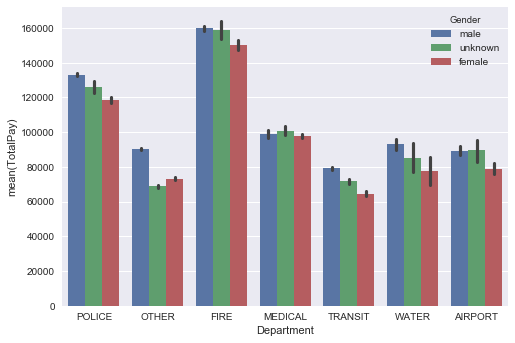

In [91]:
sns.barplot(data=sf_gender, x='Department', y='TotalPay', hue='Gender')

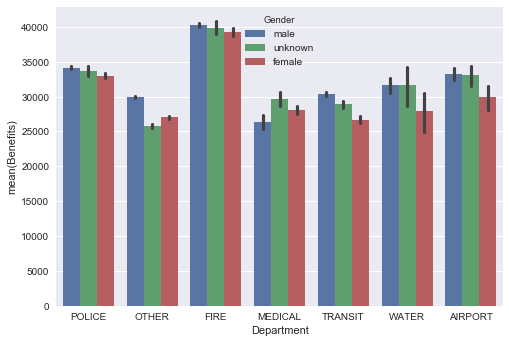

In [92]:
sns.barplot(data=sf_gender, x='Department', y='Benefits', hue='Gender')

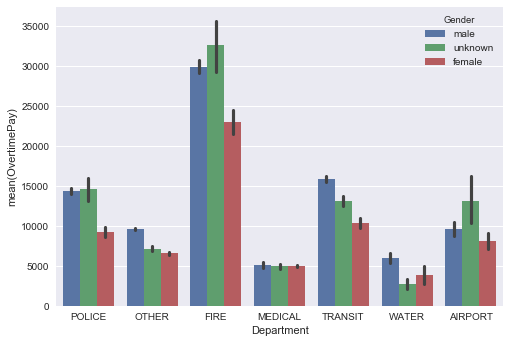

In [93]:
sns.barplot(data=sf_gender, x='Department', y='OvertimePay', hue='Gender')

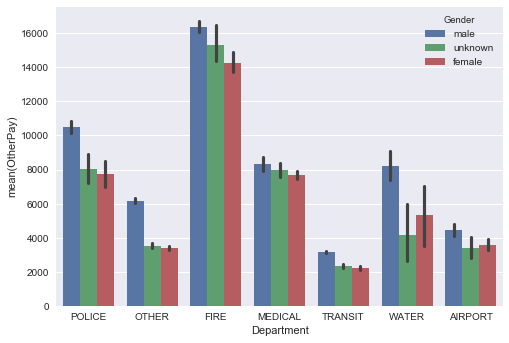

In [94]:
sns.barplot(data=sf_gender, x='Department', y='OtherPay', hue='Gender')

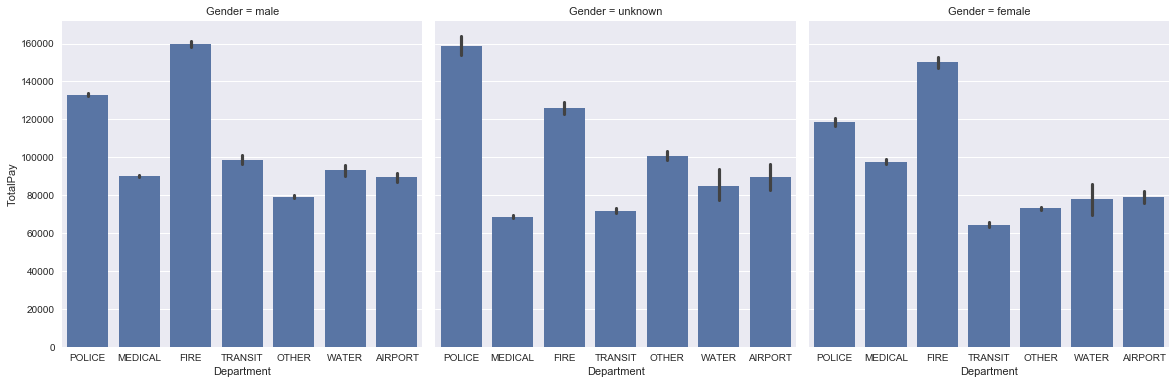

In [95]:
plot_gen = sns.FacetGrid(sf_gender, col="Gender", col_wrap=3, size=5.5, dropna=True)
plot_gen = plot_gen.map(sns.barplot, 'Department', 'TotalPay')

In [50]:
# Can you make a scatterplot?

In [51]:
# Can you make a time-series plot?

In [52]:
# How have salaries changed over time between different groups of people?

In [53]:
# How are base pay, overtime pay and benefits allocated between different groups?

In [54]:
# Is there any evidene of pay discrimination based on gender in this dataset?

In [55]:
sf_male = sf_gender[sf_gender['Gender'] == 'male']
#sf_male.pivot(columns=['Department','TotalPay'])

pd.pivot_table(sf_gender, index=['Gender', 'Department'], values=["TotalPay"], aggfunc=[np.max,np.mean, len], fill_value=0)

amax           mean      len
                     TotalPay       TotalPay TotalPay
Gender  Department                                   
female              390111.98   73218.804126     8499
        AIRPORT     139141.95   78908.031676      173
        FIRE        301697.70  150011.716743      786
        MEDICAL     274550.25   97633.275226     4332
        POLICE      297608.92  118534.132310     1108
        TRANSIT     230239.98   64349.281162     1868
        WATER       138014.34   77708.459216       51
male                332343.61   90245.954559    19714
        AIRPORT     181521.53   89321.222486      350
        FIRE        362844.66  159751.367089     4294
        MEDICAL     278569.21   98714.565177     1383
        POLICE      538909.28  132977.259684     5637
        TRANSIT     233464.63   79178.455913     7286
        WATER       184533.89   93011.041837      294
unknown             336393.73   68708.910311     4724
        AIRPORT     134120.41   89491.157037       54
        FIRE        315981.05  158761.069094      265
        MEDICAL     221930.95  100823.603375     1212
        POLICE      224813.84  125964.044099      405
        TRANSIT     223103.44   71815.584594     1837
        WATER       147123.13   85014.341282       39

In [56]:
# How is budget allocated based on different groups and responsibilities?

In [50]:
# Any 80/20 principals I can identify?

In [51]:
# Integrate ideas from here:
# https://public.tableau.com/profile/lawrence.chernin#!/vizhome/SanFranciscoSalaries/CountsbyTitle

## Questions to Explore

In [33]:
# Are there any duplicate names in the dataset?

In [34]:
# Which employee has been employed three years?

In [35]:
# What is the correlation between titles and salaries?